In [1]:
# Dependencies
import requests
import json
from private_info.config import api_key, fromdate, todate
from private_info.opendata_config import token311, password, username
import pandas as pd
from datetime import datetime
import sys
# sys.path.append('/path/to/your/dev/environment/lib/python3.10/site-packages')
from sodapy import Socrata

In the following script we'll try to analize the following
NYC311 can provide you access to non-emergency City services and information about City government programs. NYC311 can help with a broad range of services, including things like homeless person assistance, pothole repair, or help understanding a property tax bill. over 500 services
which are the top 10 most popular report ploblems 311 receives (top 3 apartment mainrenance complaint, ilegal parking and noise from neighbor)
what's the time gap they take to solve problems
what location report more issues in nyc
What burough has the highest level of 311 calls
Were the 311 calls resolved (which burough has the highest resolution rate)
Which category of service is the best/worst

#Extracting NYC API Developers data from api-portal.nyc.gov

In [2]:
# URL for GET requests to retrieve vehicle data
url_calendar= f'https://api.nyc.gov/public/api/GetCalendar?fromdate={fromdate}&todate={todate}'
headers = {'Ocp-Apim-Subscription-Key': api_key}

In [3]:
# Print the response object to the console
response = requests.get(url_calendar, headers=headers)
print(response.status_code)

200


In [4]:
# Retrieving data and converting it into JSON
response_json =response.json()

In [5]:
# Pretty Print the output of the JSON
print(json.dumps(response_json, indent=4, sort_keys=True))

{
    "days": [
        {
            "items": [
                {
                    "details": "Alternate side parking and meters are suspended for New Year's Day.",
                    "exceptionName": "New Year's Day 2024",
                    "status": "SUSPENDED",
                    "type": "Alternate Side Parking"
                },
                {
                    "details": "Trash, recycling, and compost collections are suspended for New Year's Day.",
                    "exceptionName": "New Year's Day 2024",
                    "status": "SUSPENDED",
                    "type": "Collections"
                },
                {
                    "details": "Public schools are closed for Winter Recess. Students return Tuesday.",
                    "exceptionName": "Winter Recess Last Day 2024",
                    "status": "CLOSED",
                    "type": "Schools"
                }
            ],
            "today_id": "20240101"
        },
        {
       

In [6]:
#create a dataframe from json response 
api_df = response_json
api_df

{'days': [{'today_id': '20240101',
   'items': [{'exceptionName': "New Year's Day 2024",
     'details': "Alternate side parking and meters are suspended for New Year's Day.",
     'status': 'SUSPENDED',
     'type': 'Alternate Side Parking'},
    {'exceptionName': "New Year's Day 2024",
     'details': "Trash, recycling, and compost collections are suspended for New Year's Day.",
     'status': 'SUSPENDED',
     'type': 'Collections'},
    {'exceptionName': 'Winter Recess Last Day 2024',
     'details': 'Public schools are closed for Winter Recess. Students return Tuesday.',
     'status': 'CLOSED',
     'type': 'Schools'}]},
  {'today_id': '20240102',
   'items': [{'details': 'Alternate side parking and meters are in effect.',
     'status': 'IN EFFECT',
     'type': 'Alternate Side Parking'},
    {'exceptionName': "New Year's Day Delayed 1/2 - 1/3/24",
     'details': 'Trash, recycling, and compost collections are delayed due to the backlog from the recent holiday.',
     'status': 

#Extracting the the first trimester of 2024 from 311 service request dataset open data

In [7]:
# Define date range
start_date = datetime(2024, 1, 1).isoformat()  # January 1, 2023
end_date = datetime(2024, 4, 1).isoformat()  # January 1, 2024


# Example authenticated client (needed for non-public datasets):
client = Socrata(
    "data.cityofnewyork.us",
    token311,
    username= username,
    password= password,
    timeout=1000
)

# First 794354 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
# Query dataset with date filter 
#in this case we se a limit of limit=794354 because that's the number of rows we need to get the first trimester, we cannot set it to default because it only retrive 1000 max.
results = client.get("erm2-nwe9", where=f"created_date between '{start_date}' and '{end_date}'", limit=794354)
print(len(results))
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

794354


In [8]:
#Displaying the 311 service request dataframe 
results_df

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,location,vehicle_type,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough
0,60746805,2024-04-01T00:00:00.000,2024-04-01T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211,76 AINSLIE STREET,...,"{'latitude': '40.71256007953489', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60740007,2024-03-31T23:59:36.000,2024-04-01T05:20:38.000,DOT,Department of Transportation,Street Sign - Damaged,"No Parking, Standing, Stopping",Street,11205,920 KENT AVENUE,...,"{'latitude': '40.693075024696356', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,60734332,2024-03-31T23:59:09.000,2024-04-01T09:12:45.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10454,313 EAST 140 STREET,...,"{'latitude': '40.81154285376075', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,60738841,2024-03-31T23:58:47.000,2024-04-02T22:34:59.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10128,1670 YORK AVENUE,...,"{'latitude': '40.777070197706855', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,60739109,2024-03-31T23:58:39.000,2024-04-02T15:08:50.000,DOT,Department of Transportation,Street Condition,Defective Hardware,Street,10009,324 EAST 8 STREET,...,"{'latitude': '40.72501024136251', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794349,59887043,2024-01-01T00:00:20.000,2024-01-01T00:41:01.000,NYPD,New York City Police Department,Illegal Fireworks,N/A,Street/Sidewalk,11228,7223 FORT HAMILTON PARKWAY,...,"{'latitude': '40.62709413549678', 'longitude':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794350,59896272,2024-01-01T00:00:00.000,2024-01-02T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211,145 GRAND STREET EXTENSION,...,"{'latitude': '40.710675306389646', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794351,59899838,2024-01-01T00:00:00.000,2024-01-02T09:42:25.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10022,1069 1 AVENUE,...,"{'latitude': '40.759191822016476', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794352,59894610,2024-01-01T00:00:00.000,2024-01-02T09:46:32.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,10304,7 NAVY PIER COURT,...,"{'latitude': '40.628827651071944', 'longitude'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Getting a brief summary of the results_df dataframe 
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794354 entries, 0 to 794353
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   unique_key                      794354 non-null  object
 1   created_date                    794354 non-null  object
 2   closed_date                     774309 non-null  object
 3   agency                          794354 non-null  object
 4   agency_name                     794354 non-null  object
 5   complaint_type                  794354 non-null  object
 6   descriptor                      788994 non-null  object
 7   location_type                   695950 non-null  object
 8   incident_zip                    785089 non-null  object
 9   incident_address                762451 non-null  object
 10  street_name                     762428 non-null  object
 11  cross_street_1                  502948 non-null  object
 12  cross_street_2                

In [10]:
# Get the results_df columns
results_df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough'],
      dtype='object')

In [11]:
#Assigning  location and location_subtype values to the location and location_subtype columns 
try:
    results_df[['location_', 'location_subtype']] = results_df['location_type'].str.split("/", n=1, expand=True)

except  ValueError:

    results_df['location_subtype'] = None 
results_df.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough,location_,location_subtype
0,60746805,2024-04-01T00:00:00.000,2024-04-01T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11211,76 AINSLIE STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Restaurant,Bar/Deli/Bakery
1,60740007,2024-03-31T23:59:36.000,2024-04-01T05:20:38.000,DOT,Department of Transportation,Street Sign - Damaged,"No Parking, Standing, Stopping",Street,11205,920 KENT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None
2,60734332,2024-03-31T23:59:09.000,2024-04-01T09:12:45.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10454,313 EAST 140 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
3,60738841,2024-03-31T23:58:47.000,2024-04-02T22:34:59.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10128,1670 YORK AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
4,60739109,2024-03-31T23:58:39.000,2024-04-02T15:08:50.000,DOT,Department of Transportation,Street Condition,Defective Hardware,Street,10009,324 EAST 8 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None


In [12]:

# Get the results_df columns
results_df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough', 'location_', 'location_subtype'],
      dtype='object')

In [13]:
#Doucble check how it looks like and the delete the location_type column
results_df[['location_type', 'location_','location_subtype']]
results_df_ = results_df.drop(['location_type'], axis=1)
results_df_.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough', 'location_', 'location_subtype'],
      dtype='object')

#Updating 311 service dataframe datatype

In [14]:
# Create a copy of the results_df_ dataframe 
copy_311service_request = results_df_.copy()
copy_311service_request.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough,location_,location_subtype
0,60746805,2024-04-01T00:00:00.000,2024-04-01T00:00:01.000,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,11211,76 AINSLIE STREET,AINSLIE STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Restaurant,Bar/Deli/Bakery
1,60740007,2024-03-31T23:59:36.000,2024-04-01T05:20:38.000,DOT,Department of Transportation,Street Sign - Damaged,"No Parking, Standing, Stopping",11205,920 KENT AVENUE,KENT AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None
2,60734332,2024-03-31T23:59:09.000,2024-04-01T09:12:45.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,10454,313 EAST 140 STREET,EAST 140 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
3,60738841,2024-03-31T23:58:47.000,2024-04-02T22:34:59.000,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,10128,1670 YORK AVENUE,YORK AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RESIDENTIAL BUILDING,None
4,60739109,2024-03-31T23:58:39.000,2024-04-02T15:08:50.000,DOT,Department of Transportation,Street Condition,Defective Hardware,10009,324 EAST 8 STREET,EAST 8 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Street,None


In [15]:
#Renaming the descriptor column
copy_311service_request = copy_311service_request.rename(columns={'descriptor': 'complaint_descriptor','location_': 'location_type'})

In [16]:
#reordering dataframe with location and location_subtype after descriptor 
# and we're also ignoring the 'agency_name' column since the metadata says that column is currenlty showing incorrect values.
nyc311_service_line = copy_311service_request[['unique_key', 'created_date', 'closed_date', 'agency',
       'complaint_type', 'complaint_descriptor','location_type','location_subtype', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'vehicle_type', 'facility_type',
       'due_date', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough']]

In [17]:
# # Convert the created_date, closed_date, due_date, and resolution_action_updated_date  columns to datetime format

# nyc311_service_line['created_date'] = pd.to_datetime(nyc311_service_line['created_date'])
# nyc311_service_line['closed_date'] = pd.to_datetime(nyc311_service_line['closed_date'])
# nyc311_service_line[ 'due_date'] = pd.to_datetime(nyc311_service_line['due_date'])
# nyc311_service_line['resolution_action_updated_date'] = pd.to_datetime(nyc311_service_line['resolution_action_updated_date'])

# #using loc function to avoid SettingWithCopyWarning

# Convert date columns to datetime format
date_columns = ['created_date', 'closed_date', 'due_date', 'resolution_action_updated_date']
for col in date_columns:
    nyc311_service_line.loc[:,col] = pd.to_datetime(nyc311_service_line[col])

In [18]:
# Convert latitude and longitude columns to float format
float_columns = ['latitude', 'longitude']
for float_column in float_columns:
    nyc311_service_line[float_column] = nyc311_service_line[float_column].astype(float)

# # Convert y_coordinate_state_plane and x_coordinate_state_plane columns to integer format
int_columns = ['y_coordinate_state_plane', 'x_coordinate_state_plane']
for int_column in int_columns:
    nyc311_service_line[int_column] = nyc311_service_line[int_column].fillna(0).astype(int)

#convert incident_zip and unique_key to integer columns 
integers_columns = [ 'incident_zip', 'unique_key'] # here we have the columns without Nan values 
for integer_columns in integers_columns:
    nyc311_service_line[integer_columns] = nyc311_service_line[integer_columns].fillna(0).astype(int)

C:\Users\amand\AppData\Local\Temp\ipykernel_3268\4210539024.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc311_service_line[float_column] = nyc311_service_line[float_column].astype(float)
C:\Users\amand\AppData\Local\Temp\ipykernel_3268\4210539024.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc311_service_line[float_column] = nyc311_service_line[float_column].astype(float)
C:\Users\amand\AppData\Local\Temp\ipykernel_3268\4210539024.py:9: SettingWithCopyWarning: 
A value is trying to be set o

In [19]:
# Checking the datatypes
nyc311_service_line.dtypes

unique_key                          int32
created_date                       object
closed_date                        object
agency                             object
complaint_type                     object
complaint_descriptor               object
location_type                      object
location_subtype                   object
incident_zip                        int32
incident_address                   object
street_name                        object
cross_street_1                     object
cross_street_2                     object
intersection_street_1              object
intersection_street_2              object
address_type                       object
city                               object
landmark                           object
status                             object
resolution_description             object
resolution_action_updated_date     object
community_board                    object
bbl                                object
borough                           

In [20]:

nyc311_service_line.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'complaint_type',
       'complaint_descriptor', 'location_type', 'location_subtype',
       'incident_zip', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'intersection_street_1', 'intersection_street_2',
       'address_type', 'city', 'landmark', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'bbl', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'vehicle_type', 'facility_type', 'due_date',
       'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_segment', 'bridge_highway_direction', 'road_ramp',
       'taxi_company_borough'],
      dtype='object')

In [21]:

nyc311_service_line.head()

,unique_key,created_date,closed_date,agency,complaint_type,complaint_descriptor,location_type,location_subtype,incident_zip,incident_address,...,longitude,vehicle_type,facility_type,due_date,taxi_pick_up_location,bridge_highway_name,bridge_highway_segment,bridge_highway_direction,road_ramp,taxi_company_borough
0,60746805,2024-04-01 00:00:00,2024-04-01 00:00:01,DOHMH,Food Poisoning,1 or 2,Restaurant,Bar/Deli/Bakery,11211,76 AINSLIE STREET,...,-73.951899,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,60740007,2024-03-31 23:59:36,2024-04-01 05:20:38,DOT,Street Sign - Damaged,"No Parking, Standing, Stopping",Street,None,11205,920 KENT AVENUE,...,-73.959093,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,60734332,2024-03-31 23:59:09,2024-04-01 09:12:45,HPD,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,None,10454,313 EAST 140 STREET,...,-73.924611,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,60738841,2024-03-31 23:58:47,2024-04-02 22:34:59,HPD,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,None,10128,1670 YORK AVENUE,...,-73.946274,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,60739109,2024-03-31 23:58:39,2024-04-02 15:08:50,DOT,Street Condition,Defective Hardware,Street,None,10009,324 EAST 8 STREET,...,-73.979179,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:

# Create the nyc311 location dataframe 
nyc311_location =nyc311_service_line[['unique_key', 'borough', 'latitude', 'longitude', 'x_coordinate_state_plane', 'y_coordinate_state_plane','due_date']]
nyc311_location.head()

,unique_key,borough,latitude,longitude,x_coordinate_state_plane,y_coordinate_state_plane,due_date
0,60746805,BROOKLYN,40.712560,-73.951899,997585,198885,NaT
1,60740007,BROOKLYN,40.693075,-73.959093,995594,191785,NaT
2,60734332,BRONX,40.811543,-73.924611,1005119,234953,NaT
3,60738841,MANHATTAN,40.777070,-73.946274,999130,222389,NaT
4,60739109,MANHATTAN,40.725010,-73.979179,990021,203418,NaT


In [23]:
#Create borough dataframe
nyc311_borough =nyc311_service_line[['unique_key', 'borough', 'latitude', 'longitude', 'x_coordinate_state_plane', 'y_coordinate_state_plane','complaint_type','complaint_descriptor']]
nyc311_borough.tail()

,unique_key,borough,latitude,longitude,x_coordinate_state_plane,y_coordinate_state_plane,complaint_type,complaint_descriptor
794349,59887043,BROOKLYN,40.627094,-74.014497,980226,167744,Illegal Fireworks,N/A
794350,59896272,BROOKLYN,40.710675,-73.954050,996989,198198,Food Poisoning,1 or 2
794351,59899838,MANHATTAN,40.759192,-73.962290,994697,215873,Food Poisoning,1 or 2
794352,59894610,STATEN ISLAND,40.628828,-74.074387,963602,168384,Food Poisoning,1 or 2
794353,59898042,BRONX,40.845340,-73.865594,1021437,247286,Food Poisoning,1 or 2


In [24]:
# Counts Instances of each Borough Grouped by Complaint
borough_complaint_counts = nyc311_service_line.groupby("complaint_type")["borough"].value_counts()


#AMANDA'S CODE STARTS HERE

In [25]:
#Finding the unique value of agencies. I am looking to see which agencies are taking care of the complaints at NYC311 and how many /
# complaints they each got between 01/01/24 and 04/01/24.
unique_agency = nyc311_service_line["agency"].value_counts()
unique_agency

agency
NYPD     316884
HPD      228164
DSNY      65662
DOT       53678
DEP       38572
DOB       24812
DPR       19684
DOHMH     19168
TLC        8869
DHS        7190
EDC        7006
DCWP       4256
DOE         370
OTI          39
Name: count, dtype: int64

In [27]:
#Creating a dataframe referencing only the complaint types and the corresponding agencies. This will be the dataframe used to create my other / 
#following dataframes for my visualizations
agency_per_complaint = nyc311_service_line[['complaint_type', 'agency']]
agency_per_complaint

,complaint_type,agency
0,Food Poisoning,DOHMH
1,Street Sign - Damaged,DOT
2,HEAT/HOT WATER,HPD
3,HEAT/HOT WATER,HPD
4,Street Condition,DOT
...,...,...
794349,Illegal Fireworks,NYPD
794350,Food Poisoning,DOHMH
794351,Food Poisoning,DOHMH
794352,Food Poisoning,DOHMH


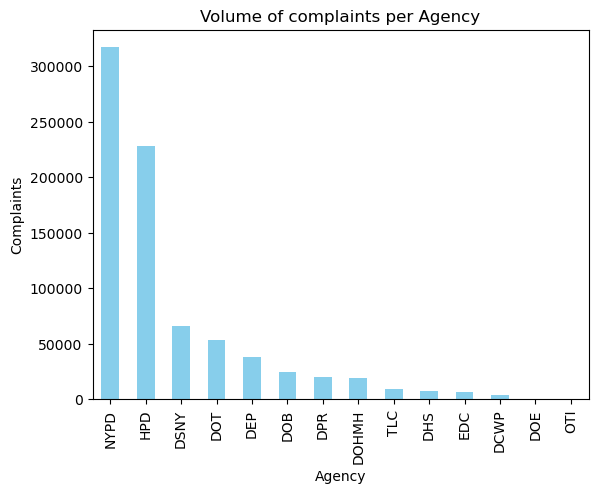

In [30]:
import matplotlib.pyplot as plt

unique_agency.plot(x='agency', y='complaint_type', kind='bar', color='skyblue')


plt.xlabel('Agency')
plt.ylabel('Complaints')
plt.title('Volume of complaints per Agency')

plt.show()

In [70]:
# Saving visualization
plt.savefig('Resources/Volume of complaints per agency.png')

<Figure size 640x480 with 0 Axes>

In [31]:
#Here I just wanted to see what the abbreviations meant.
unique_agency_name = results_df_["agency_name"].value_counts()
unique_agency_name

agency_name
New York City Police Department                       316884
Department of Housing Preservation and Development    228164
Department of Sanitation                               65662
Department of Transportation                           53678
Department of Environmental Protection                 38572
Department of Buildings                                24812
Department of Parks and Recreation                     19684
Department of Health and Mental Hygiene                19168
Taxi and Limousine Commission                           8869
Department of Homeless Services                         7190
Economic Development Corporation                        7006
Department of Consumer and Worker Protection            4256
Department of Education                                  370
Office of Technology and Innovation                       39
Name: count, dtype: int64

In [32]:
#Calculating for count of complaints for each complaint type only for NYPD.
nypd_complaints = agency_per_complaint.query('agency == "NYPD"').groupby('complaint_type').size().reset_index(name='NYPD')
nypd_complaints = nypd_complaints.sort_values(by=['NYPD', 'complaint_type'])
nypd_complaints = nypd_complaints.reset_index(drop=True)
print(nypd_complaints)


                 complaint_type    NYPD
0                      Squeegee       8
1         Posting Advertisement      21
2              Disorderly Youth      44
3           Urinating in Public     130
4      Noise - House of Worship     171
5                      Graffiti     271
6                      Drinking     516
7                  Noise - Park     584
8             Illegal Fireworks     600
9                       Traffic     945
10                  Panhandling    1846
11                 Animal-Abuse    2066
12    Bike/Roller/Skate Chronic    3000
13                Drug Activity    4422
14                   Encampment    4909
15  Non-Emergency Police Matter    5098
16              Noise - Vehicle    9093
17           Noise - Commercial   15165
18      Noise - Street/Sidewalk   15722
19            Abandoned Vehicle   17625
20             Blocked Driveway   43067
21          Noise - Residential   68498
22              Illegal Parking  123083


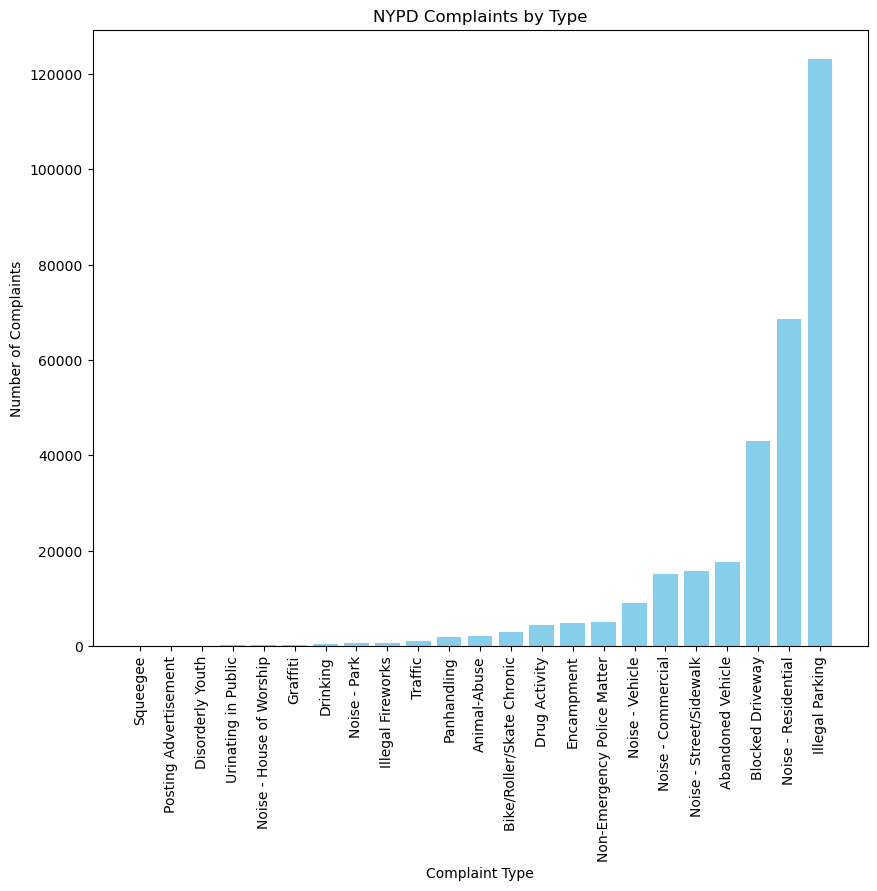

In [33]:
# Creating a histogram for NYPD using the previous data from nypd_complaints.
plt.figure(figsize=(10,8))
plt.bar(nypd_complaints['complaint_type'], nypd_complaints['NYPD'], color='skyblue')
plt.title('NYPD Complaints by Type')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=90)
nypd_complaints.sort_values('complaint_type')
plt.show()

In [69]:
# Saving visualization
plt.savefig('Resources/NYPD complaints by type.png')

<Figure size 640x480 with 0 Axes>

In [34]:
# Creating a new dataframe with the columns: agency, complaint_type and created_date. 
nypd_date = nyc311_service_line[(nyc311_service_line['agency'] == 'NYPD')]
nypd_date = nypd_date[['agency', 'complaint_type', 'created_date']]
nypd_date

,agency,complaint_type,created_date
5,NYPD,Noise - Residential,2024-03-31 23:58:32
6,NYPD,Noise - Commercial,2024-03-31 23:58:22
7,NYPD,Illegal Parking,2024-03-31 23:58:21
8,NYPD,Noise - Street/Sidewalk,2024-03-31 23:58:12
9,NYPD,Illegal Parking,2024-03-31 23:57:53
...,...,...,...
794345,NYPD,Noise - Street/Sidewalk,2024-01-01 00:00:48
794346,NYPD,Illegal Fireworks,2024-01-01 00:00:46
794347,NYPD,Noise - Residential,2024-01-01 00:00:43
794348,NYPD,Noise - Residential,2024-01-01 00:00:20


In [35]:
#I am now analyzing the top 3 complaints for NYPD. NYPD is number one./
# Creating a dataframe referencing the total number of illegal parking complaints for each day between 01/01/24 and 04/01/24.
nypd_date['created_date'] = pd.to_datetime(nypd_date['created_date'])
nypd_date['created_date'] = nypd_date['created_date'].dt.date
illegal_parking_counts = nypd_date[nypd_date['complaint_type'] == 'Illegal Parking'].groupby('created_date').size().reset_index(name='Illegal parking')
illegal_parking_counts


,created_date,Illegal parking
0,2024-01-01,1167
1,2024-01-02,1410
2,2024-01-03,1468
3,2024-01-04,1519
4,2024-01-05,1497
...,...,...
86,2024-03-27,1459
87,2024-03-28,1179
88,2024-03-29,1407
89,2024-03-30,1265


In [36]:
# Creating a dataframe referencing the total number of residential noise complaints for each day between 01/01/24 and 04/01/24.
nypd_date['created_date'] = pd.to_datetime(nypd_date['created_date'])
nypd_date['created_date'] = nypd_date['created_date'].dt.date
noise_residential_counts = nypd_date[nypd_date['complaint_type'] == 'Noise - Residential'].groupby('created_date').size().reset_index(name='Residential noise')
noise_residential_counts

,created_date,Residential noise
0,2024-01-01,1481
1,2024-01-02,605
2,2024-01-03,657
3,2024-01-04,562
4,2024-01-05,605
...,...,...
86,2024-03-27,652
87,2024-03-28,627
88,2024-03-29,722
89,2024-03-30,1224


In [37]:
# Creating a dataframe referencing the total number of blocked driveway complaints for each day between 01/01/24 and 04/01/24.
nypd_date['created_date'] = pd.to_datetime(nypd_date['created_date'])
nypd_date['created_date'] = nypd_date['created_date'].dt.date
blocked_driveway_counts = nypd_date[nypd_date['complaint_type'] == 'Blocked Driveway'].groupby('created_date').size().reset_index(name='Blocked driveway')
blocked_driveway_counts

,created_date,Blocked driveway
0,2024-01-01,573
1,2024-01-02,500
2,2024-01-03,485
3,2024-01-04,509
4,2024-01-05,534
...,...,...
86,2024-03-27,422
87,2024-03-28,404
88,2024-03-29,432
89,2024-03-30,444


In [38]:
#Merging all three dataframes to create a line graph and study the evolution of the three NYPD biggest complaints over 3 months. 
nypd_complaints_counts = illegal_parking_counts.merge(noise_residential_counts, on='created_date', how='outer').merge(blocked_driveway_counts, on='created_date', how='outer').fillna(0)
nypd_complaints_counts

,created_date,Illegal parking,Residential noise,Blocked driveway
0,2024-01-01,1167,1481,573
1,2024-01-02,1410,605,500
2,2024-01-03,1468,657,485
3,2024-01-04,1519,562,509
4,2024-01-05,1497,605,534
...,...,...,...,...
86,2024-03-27,1459,652,422
87,2024-03-28,1179,627,404
88,2024-03-29,1407,722,432
89,2024-03-30,1265,1224,444


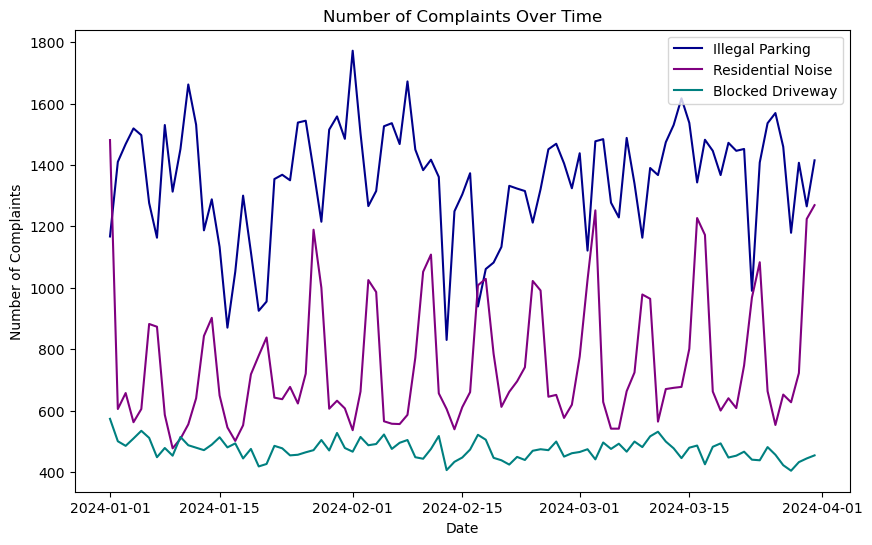

In [39]:
# Creating line graph
# Convert the 'created_date' column to datetime objects
nypd_complaints_counts['created_date'] = pd.to_datetime(nypd_complaints_counts['created_date'])

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(nypd_complaints_counts['created_date'], nypd_complaints_counts['Illegal parking'], label='Illegal Parking', color='darkblue')
plt.plot(nypd_complaints_counts['created_date'], nypd_complaints_counts['Residential noise'], label='Residential Noise', color='purple')
plt.plot(nypd_complaints_counts['created_date'], nypd_complaints_counts['Blocked driveway'], label='Blocked Driveway', color='teal')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints Over Time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [68]:
# Saving visualization
plt.savefig('Resources/Number of complaints over time NYPD.png')

<Figure size 640x480 with 0 Axes>

In [40]:
#Calculating for count of complaints for each complaint type only for HPD.
hpd_complaints = agency_per_complaint.query('agency == "HPD"').groupby('complaint_type').size().reset_index(name='HPD')
hpd_complaints = hpd_complaints.sort_values(by=['HPD', 'complaint_type'])
hpd_complaints = hpd_complaints.reset_index(drop=True)
print(hpd_complaints)

          complaint_type     HPD
0       OUTSIDE BUILDING     394
1               ELEVATOR     401
2                 SAFETY    3333
3              APPLIANCE    5353
4        FLOORING/STAIRS    7137
5               ELECTRIC    7222
6                GENERAL    8257
7            DOOR/WINDOW   12755
8             WATER LEAK   13933
9          PAINT/PLASTER   17331
10              PLUMBING   17406
11  UNSANITARY CONDITION   28192
12        HEAT/HOT WATER  106450


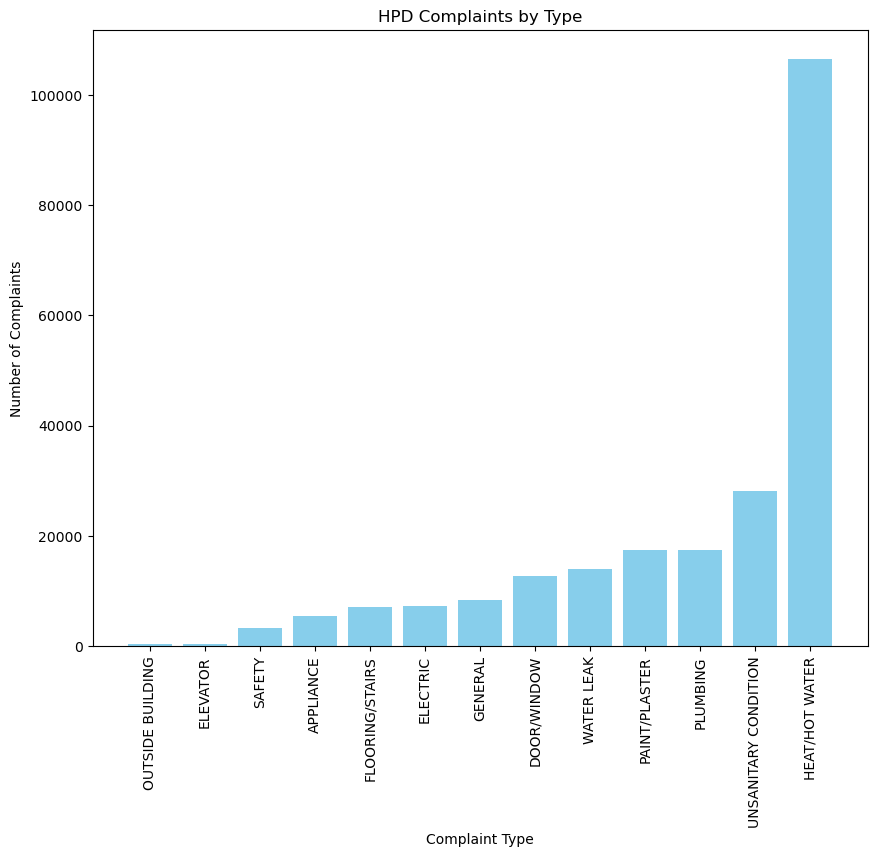

In [41]:
# Creating a histogram for HPD using the previous data from hpd_complaints.
plt.figure(figsize=(10,8))
plt.bar(hpd_complaints['complaint_type'], hpd_complaints['HPD'], color='skyblue')
plt.title('HPD Complaints by Type')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=90)
hpd_complaints.sort_values('complaint_type')
plt.show()

In [67]:
# Saving visualization
plt.savefig('Resources/HPD Complaints by type.png')

<Figure size 640x480 with 0 Axes>

In [42]:
# Creating a new dataframe with the columns: agency, complaint_type and created_date. 
hpd_date = nyc311_service_line[(nyc311_service_line['agency'] == 'HPD')]
hpd_date = hpd_date[['agency', 'complaint_type', 'created_date']]
hpd_date

,agency,complaint_type,created_date
2,HPD,HEAT/HOT WATER,2024-03-31 23:59:09
3,HPD,HEAT/HOT WATER,2024-03-31 23:58:47
22,HPD,HEAT/HOT WATER,2024-03-31 23:55:44
42,HPD,HEAT/HOT WATER,2024-03-31 23:52:15
67,HPD,WATER LEAK,2024-03-31 23:46:32
...,...,...,...
794249,HPD,HEAT/HOT WATER,2024-01-01 00:13:42
794336,HPD,HEAT/HOT WATER,2024-01-01 00:01:45
794340,HPD,PAINT/PLASTER,2024-01-01 00:01:14
794341,HPD,WATER LEAK,2024-01-01 00:01:14


In [43]:
#I am now analyzing the top 3 complaints for HPD. HPD is number two./
# Creating a dataframe referencing the total number of HEAT/HOT WATER complaints for each day between 01/01/24 and 04/01/24.
hpd_date['created_date'] = pd.to_datetime(hpd_date['created_date'])
hpd_date['created_date'] = hpd_date['created_date'].dt.date
heat_hot_water_counts = hpd_date[hpd_date['complaint_type'] == 'HEAT/HOT WATER'].groupby('created_date').size().reset_index(name='HEAT/HOT WATER')
heat_hot_water_counts

,created_date,HEAT/HOT WATER
0,2024-01-01,850
1,2024-01-02,1496
2,2024-01-03,1327
3,2024-01-04,1495
4,2024-01-05,1934
...,...,...
86,2024-03-27,793
87,2024-03-28,628
88,2024-03-29,716
89,2024-03-30,606


In [44]:
# Creating a dataframe referencing the total number of UNSANITARY CONDITION complaints for each day between 01/01/24 and 04/01/24.
hpd_date['created_date'] = pd.to_datetime(hpd_date['created_date'])
hpd_date['created_date'] = hpd_date['created_date'].dt.date
unsanitary_condition_counts = hpd_date[hpd_date['complaint_type'] == 'UNSANITARY CONDITION'].groupby('created_date').size().reset_index(name='UNSANITARY CONDITION')
unsanitary_condition_counts

,created_date,UNSANITARY CONDITION
0,2024-01-01,162
1,2024-01-02,383
2,2024-01-03,426
3,2024-01-04,458
4,2024-01-05,367
...,...,...
86,2024-03-27,299
87,2024-03-28,291
88,2024-03-29,238
89,2024-03-30,154


In [45]:
# Creating a dataframe referencing the total number of PLUMBING complaints for each day between 01/01/24 and 04/01/24.
hpd_date['created_date'] = pd.to_datetime(hpd_date['created_date'])
hpd_date['created_date'] = hpd_date['created_date'].dt.date
plumbing_counts = hpd_date[hpd_date['complaint_type'] == 'PLUMBING'].groupby('created_date').size().reset_index(name='PLUMBING')
plumbing_counts

,created_date,PLUMBING
0,2024-01-01,104
1,2024-01-02,252
2,2024-01-03,239
3,2024-01-04,263
4,2024-01-05,215
...,...,...
86,2024-03-27,223
87,2024-03-28,215
88,2024-03-29,135
89,2024-03-30,93


In [46]:
#Merging all three dataframes to create a line graph and study the evolution of the three HPD biggest complaints over 3 months. 
hpd_complaints_counts = heat_hot_water_counts.merge(unsanitary_condition_counts, on='created_date', how='outer').merge(plumbing_counts, on='created_date', how='outer').fillna(0)
hpd_complaints_counts

,created_date,HEAT/HOT WATER,UNSANITARY CONDITION,PLUMBING
0,2024-01-01,850,162,104
1,2024-01-02,1496,383,252
2,2024-01-03,1327,426,239
3,2024-01-04,1495,458,263
4,2024-01-05,1934,367,215
...,...,...,...,...
86,2024-03-27,793,299,223
87,2024-03-28,628,291,215
88,2024-03-29,716,238,135
89,2024-03-30,606,154,93


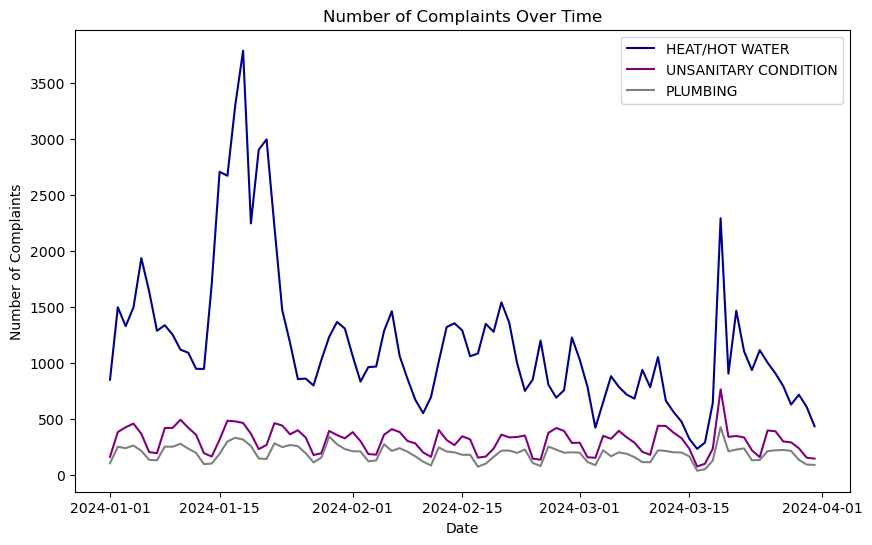

In [47]:
# Creating line graph
# Convert the 'created_date' column to datetime objects
hpd_complaints_counts['created_date'] = pd.to_datetime(hpd_complaints_counts['created_date'])

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(hpd_complaints_counts['created_date'], hpd_complaints_counts['HEAT/HOT WATER'], label='HEAT/HOT WATER', color='darkblue')
plt.plot(hpd_complaints_counts['created_date'], hpd_complaints_counts['UNSANITARY CONDITION'], label='UNSANITARY CONDITION', color='purple')
plt.plot(hpd_complaints_counts['created_date'], hpd_complaints_counts['PLUMBING'], label='PLUMBING', color='grey')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints Over Time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [66]:
# Saving visualization
plt.savefig('Resources/Number of complaints over time HPD.png')

<Figure size 640x480 with 0 Axes>

In [48]:
#Calculating for count of complaints for each complaint type only for DSNY.
dsny_complaints = agency_per_complaint.query('agency == "DSNY"').groupby('complaint_type').size().reset_index(name='DSNY')
dsny_complaints = dsny_complaints.sort_values(by=['DSNY', 'complaint_type'])
dsny_complaints = dsny_complaints.reset_index(drop=True)
print(dsny_complaints)

                            complaint_type   DSNY
0                            DSNY Internal      1
1                         Oil or Gas Spill      2
2                           Incorrect Data      5
3           Institution Disposal Complaint      9
4                       Retailer Complaint      9
5               Recycling Basket Complaint     10
6                           Adopt-A-Basket     14
7                      Seasonal Collection    140
8                  Litter Basket Complaint    207
9                            Lot Condition    264
10                      Dumpster Complaint    378
11                          Abandoned Bike    533
12  Sanitation Worker or Vehicle Complaint    580
13                   Litter Basket Request    777
14                         Illegal Posting    908
15           Commercial Disposal Complaint   1018
16               Street Sweeping Complaint   1644
17                             Dead Animal   2014
18          Residential Disposal Complaint   2912


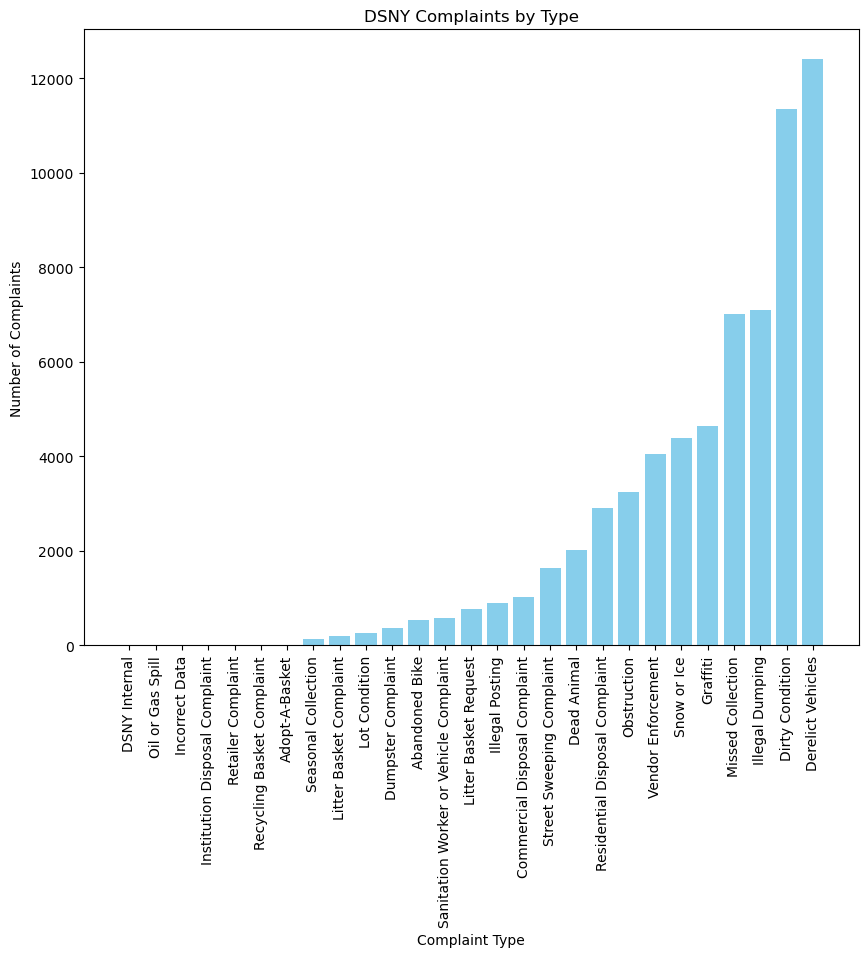

In [49]:
# Creating a histogram for HPD using the previous data from dsny_complaints.
plt.figure(figsize=(10,8))
plt.bar(dsny_complaints['complaint_type'], dsny_complaints['DSNY'], color='skyblue')
plt.title('DSNY Complaints by Type')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=90)
dsny_complaints.sort_values('complaint_type')
plt.show()

In [65]:
# Saving visualization
plt.savefig('Resources/DSNY Complaints by type.png')

<Figure size 640x480 with 0 Axes>

In [50]:
# Creating a new dataframe with the columns: agency, complaint_type and created_date. 
dsny_date = nyc311_service_line[(nyc311_service_line['agency'] == 'DSNY')]
dsny_date = dsny_date[['agency', 'complaint_type', 'created_date']]
dsny_date

,agency,complaint_type,created_date
27,DSNY,Derelict Vehicles,2024-03-31 23:55:00
32,DSNY,Graffiti,2024-03-31 23:53:43
75,DSNY,Illegal Dumping,2024-03-31 23:45:43
169,DSNY,Obstruction,2024-03-31 23:32:29
235,DSNY,Dirty Condition,2024-03-31 23:21:54
...,...,...,...
793537,DSNY,Obstruction,2024-01-01 01:33:48
793776,DSNY,Dirty Condition,2024-01-01 01:06:41
793791,DSNY,Dirty Condition,2024-01-01 01:04:16
793906,DSNY,Dead Animal,2024-01-01 00:51:43


In [51]:
#I am now analyzing the top 4 complaints for HPD. HPD is number two./
#I am analyzing the 4th biggest complaint because Missed Collection is linked to the current NYC trash problem.
# Creating a dataframe referencing the total number of Derelict Vehicles complaints for each day between 01/01/24 and 04/01/24.
dsny_date['created_date'] = pd.to_datetime(dsny_date['created_date'])
dsny_date['created_date'] = dsny_date['created_date'].dt.date
derelict_vehicles_counts = dsny_date[dsny_date['complaint_type'] == 'Derelict Vehicles'].groupby('created_date').size().reset_index(name='Derelict Vehicles')
derelict_vehicles_counts

,created_date,Derelict Vehicles
0,2024-01-01,82
1,2024-01-02,132
2,2024-01-03,150
3,2024-01-04,178
4,2024-01-05,164
...,...,...
86,2024-03-27,157
87,2024-03-28,115
88,2024-03-29,95
89,2024-03-30,103


In [52]:
# Creating a dataframe referencing the total number of Dirty Condition complaints for each day between 01/01/24 and 04/01/24.
dsny_date['created_date'] = pd.to_datetime(dsny_date['created_date'])
dsny_date['created_date'] = dsny_date['created_date'].dt.date
dirty_condition_counts = dsny_date[dsny_date['complaint_type'] == 'Dirty Condition'].groupby('created_date').size().reset_index(name='Dirty Condition')
dirty_condition_counts

,created_date,Dirty Condition
0,2024-01-01,99
1,2024-01-02,172
2,2024-01-03,223
3,2024-01-04,201
4,2024-01-05,136
...,...,...
86,2024-03-27,140
87,2024-03-28,94
88,2024-03-29,97
89,2024-03-30,101


In [53]:
# Creating a dataframe referencing the total number of Illegal Dumping complaints for each day between 01/01/24 and 04/01/24.
dsny_date['created_date'] = pd.to_datetime(dsny_date['created_date'])
dsny_date['created_date'] = dsny_date['created_date'].dt.date
illegal_dumping_counts = dsny_date[dsny_date['complaint_type'] == 'Illegal Dumping'].groupby('created_date').size().reset_index(name='Illegal Dumping')
illegal_dumping_counts

,created_date,Illegal Dumping
0,2024-01-01,55
1,2024-01-02,121
2,2024-01-03,127
3,2024-01-04,138
4,2024-01-05,110
...,...,...
86,2024-03-27,102
87,2024-03-28,77
88,2024-03-29,85
89,2024-03-30,50


In [54]:
# Creating a dataframe referencing the total number of Missed Collection complaints for each day between 01/01/24 and 04/01/24.
dsny_date['created_date'] = pd.to_datetime(dsny_date['created_date'])
dsny_date['created_date'] = dsny_date['created_date'].dt.date
missed_collection_counts = dsny_date[dsny_date['complaint_type'] == 'Missed Collection'].groupby('created_date').size().reset_index(name='Missed Collection')
missed_collection_counts

,created_date,Missed Collection
0,2024-01-01,17
1,2024-01-02,15
2,2024-01-03,3
3,2024-01-04,7
4,2024-01-05,159
...,...,...
73,2024-03-27,101
74,2024-03-28,89
75,2024-03-29,112
76,2024-03-30,75


In [55]:
#Merging all four dataframes to create a line graph and study the evolution of the three HPD biggest complaints over 3 months. 
dsny_complaints_counts = derelict_vehicles_counts.merge(dirty_condition_counts, on='created_date', how='outer').merge(illegal_dumping_counts, on='created_date', how='outer').merge(missed_collection_counts, on='created_date', how='outer').fillna(0)
dsny_complaints_counts

,created_date,Derelict Vehicles,Dirty Condition,Illegal Dumping,Missed Collection
0,2024-01-01,82,99,55,17.0
1,2024-01-02,132,172,121,15.0
2,2024-01-03,150,223,127,3.0
3,2024-01-04,178,201,138,7.0
4,2024-01-05,164,136,110,159.0
...,...,...,...,...,...
86,2024-03-27,157,140,102,101.0
87,2024-03-28,115,94,77,89.0
88,2024-03-29,95,97,85,112.0
89,2024-03-30,103,101,50,75.0


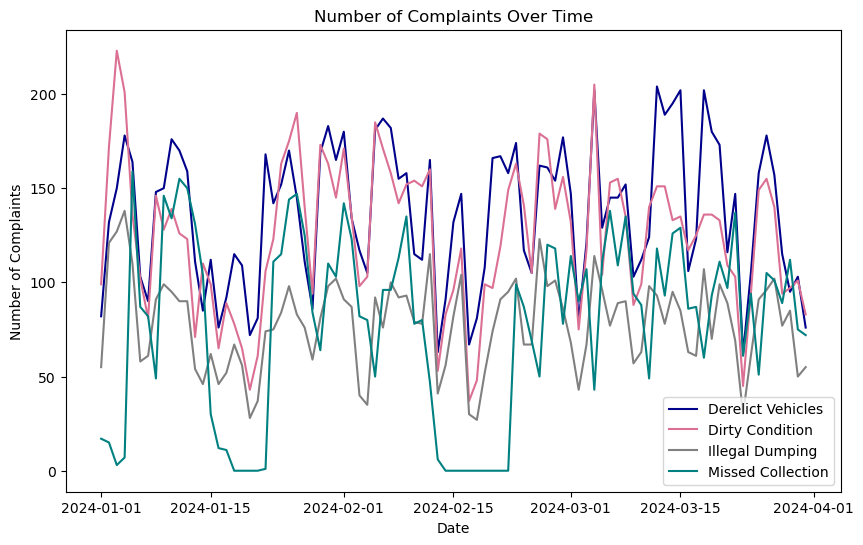

In [56]:
# Creating line graph
# Convert the 'created_date' column to datetime objects
dsny_complaints_counts['created_date'] = pd.to_datetime(dsny_complaints_counts['created_date'])

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(dsny_complaints_counts['created_date'], dsny_complaints_counts['Derelict Vehicles'], label='Derelict Vehicles', color='darkblue')
plt.plot(dsny_complaints_counts['created_date'], dsny_complaints_counts['Dirty Condition'], label='Dirty Condition', color='palevioletred')
plt.plot(dsny_complaints_counts['created_date'], dsny_complaints_counts['Illegal Dumping'], label='Illegal Dumping', color='grey')
plt.plot(dsny_complaints_counts['created_date'], dsny_complaints_counts['Missed Collection'], label='Missed Collection', color='teal')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.title('Number of Complaints Over Time')

# Add a legend
plt.legend()

# Display the plot
plt.show()

In [64]:
# Saving visualization
plt.savefig('Resources/Number of complaints over time DSNY.png')

<Figure size 640x480 with 0 Axes>

In [57]:
#Now let's look at the trash problem in NYC. I have done a quick analysis of trash collection. Should NYC get trash cans or not ? 
#Create a empty list to store data
rows = []
# Loop through the data and extract information
for day in api_df['days']:
    today_id = day['today_id']
    for type in day['items']:
        row = {'today_id': today_id}
        row.update(type)
        rows.append(row)
trash_cleaned_df = pd.DataFrame(rows)
#Display dataframe 
trash_cleaned_df

,today_id,exceptionName,details,status,type
0,20240101,New Year's Day 2024,Alternate side parking and meters are suspende...,SUSPENDED,Alternate Side Parking
1,20240101,New Year's Day 2024,"Trash, recycling, and compost collections are ...",SUSPENDED,Collections
2,20240101,Winter Recess Last Day 2024,Public schools are closed for Winter Recess. S...,CLOSED,Schools
3,20240102,NaN,Alternate side parking and meters are in effect.,IN EFFECT,Alternate Side Parking
4,20240102,New Year's Day Delayed 1/2 - 1/3/24,"Trash, recycling, and compost collections are ...",DELAYED,Collections
...,...,...,...,...,...
130,20240213,Lincoln's Birthday and Snow Delayed 2/13 - 2/1...,"Trash, recycling, and compost collections are ...",DELAYED,Collections
131,20240213,Snow 2/13/2024,All public school students are scheduled for r...,REMOTE ONLY,Schools
132,20240214,Ash Wednesday 2024,Alternate side parking is suspended for Ash We...,SUSPENDED,Alternate Side Parking
133,20240214,Lincoln's Birthday and Snow Delayed 2/13 - 2/1...,"Trash, recycling, and compost collections are ...",DELAYED,Collections


In [58]:
#Creating a dataframe with today_id, status and type
collections_list = []

# Iterating over each 'day' in the 'days' column of api_df
for day in api_df['days']:
    # Iterating over each 'item' in the 'items' list of the current 'day'
    for item in day['items']:
        # Appending a dictionary to collections_list for each 'item'
        collections_list.append({
            'today_id': day['today_id'],  # Storing 'today_id' from the current 'day'
            'status': item['status'],     # Storing 'status' from the current 'item'
            'type': item['type']          # Storing 'type' from the current 'item'
        })

# Creating a DataFrame using collections_list
types_df = pd.DataFrame(collections_list)

# Filtering rows in types_df where 'type' column equals 'Collections'
specific_type = 'Collections'
trash_filtered_df = types_df[types_df['type'] == specific_type]

# Displaying the first few rows of the filtered DataFrame
trash_filtered_df

,today_id,status,type
1,20240101,SUSPENDED,Collections
4,20240102,DELAYED,Collections
7,20240103,DELAYED,Collections
10,20240104,ON SCHEDULE,Collections
13,20240105,ON SCHEDULE,Collections
16,20240106,ON SCHEDULE,Collections
19,20240107,NOT IN EFFECT,Collections
22,20240108,ON SCHEDULE,Collections
25,20240109,ON SCHEDULE,Collections
28,20240110,ON SCHEDULE,Collections


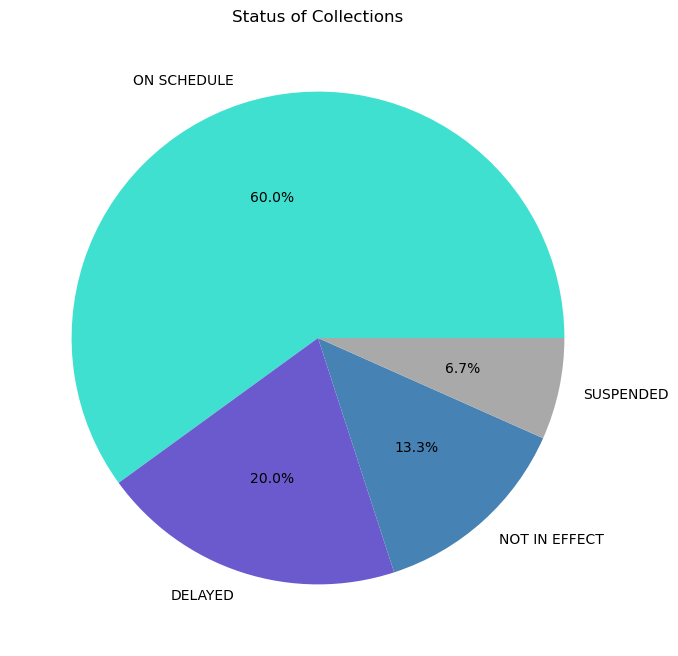

In [59]:
#Creating a piechart to diplay the results
# Counting the occurrences of each status
status_counts = trash_filtered_df['status'].value_counts()

# Creating a pie chart
plt.figure(figsize=(10,8))
plt.pie(status_counts, labels = status_counts.index, autopct='%1.1f%%', colors=['#40E0D0', '#6A5ACD', '#4682B4', '#A9A9A9'])
plt.title('Status of Collections')
plt.show()

In [63]:
# Saving visualization
plt.savefig('Resources/Status of collection.png')

<Figure size 640x480 with 0 Axes>